In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re, os

# Поиск мотива в последовательности с помощью позиционно-весовой матрицы:

In [ ]:
def plot_profile(seq: str, profile: dict[tuple, float], motif_len: int) -> None:

    # посчитать типа скользящий максимум, чтоб получить профиль для рисования
    profile_np = list(profile.values())
    temp = [profile_np[i - motif_len + 1 if i - motif_len + 1 > 0
        else 0:(i if i < len(seq) - motif_len
                else len(seq) - motif_len) + 1]
        for i in range(len(seq))]
    profile_res = [max(i) for i in temp]

    # draw results
    fig, ax = plt.subplots(dpi=100, figsize=(15, 4))
    ax.plot(profile_res)
    ax.set_xticks(list(range(len(profile_res))), labels=list(seq))
    ax.set_xlabel("Sequence")
    ax.set_ylabel("Weight")


class MotifFinderPWM:

    bases = {"A": 0, "C": 1, "G": 2, "T": 3}
    bg = 0.25

    def __init__(self, pcm: dict[str, list[float]]):
        self.pcm = pcm
        self.pwm = self.pcm2pwm(pcm)
        self.motif_len = self.pwm.shape[1]


    @staticmethod
    def pcm2pwm(pcm: dict[str, list[float]]) -> np.array:
        """
        get PWM from PCM
        """
        pcm = {i: pcm[i] for i in "ACGT"}
        pcm = np.array(list(pcm.values()))
        pwm = pcm * np.log2(pcm / MotifFinderPWM.bg)
        pwm = np.nan_to_num(pwm, nan=-np.inf)
        return pwm


    def scan(self, seq: str, plot=False) -> dict[tuple, float]:
        """
        scan sequence using pwm
        """
        profile = {}

        # проходим окном по всей последовательности
        for i in range(0, len(seq) - self.motif_len + 1):
            cand = seq[i:i+self.motif_len]

            # в каждом окне считаем вес мотива
            weight = 0
            for pos, base in enumerate(cand):
                weight += self.pwm[self.bases[base], pos]
            profile[(i, i+self.motif_len)] = weight

        if plot:
            plot_profile(seq, profile, self.motif_len)

        return profile

In [ ]:
seq = "aatcgCCCTCgaCCGTCtcgatcaaaaagtaCCCTTaatc".upper()

In [ ]:
ctcf_pcm = {"A": [0, 0, 0, 0, 0],
       "C": [1, 1, 1, 0, 1],
       "T": [0, 0, 0, 1, 0],
       "G": [0, 0, 0, 0, 0]}

<ipython-input-71-066f77279dc9>:37: RuntimeWarning: divide by zero encountered in log2
  pwm = pcm * np.log2(pcm / MotifFinderPWM.bg)
<ipython-input-71-066f77279dc9>:37: RuntimeWarning: invalid value encountered in multiply
  pwm = pcm * np.log2(pcm / MotifFinderPWM.bg)


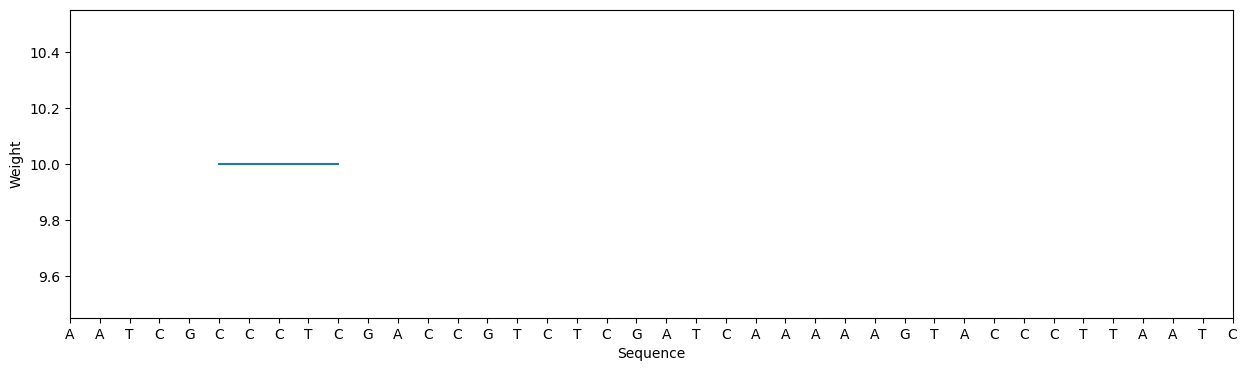

In [ ]:
ctcf_finder = MotifFinderPWM(ctcf_pcm)
profile = ctcf_finder.scan(seq, plot=True)

In [ ]:
ctcf_pcm = {"A": [0.1, 0.03, 0.05, 0.01, 0.1],
            "C": [0.7, 0.91, 0.5 , 0.01, 0.7],
            "T": [0.1, 0.03, 0.05, 0.97, 0],
            "G": [0.1, 0.03, 0.4,  0.01, 0.2]}

<ipython-input-71-066f77279dc9>:37: RuntimeWarning: divide by zero encountered in log2
  pwm = pcm * np.log2(pcm / MotifFinderPWM.bg)
<ipython-input-71-066f77279dc9>:37: RuntimeWarning: invalid value encountered in multiply
  pwm = pcm * np.log2(pcm / MotifFinderPWM.bg)


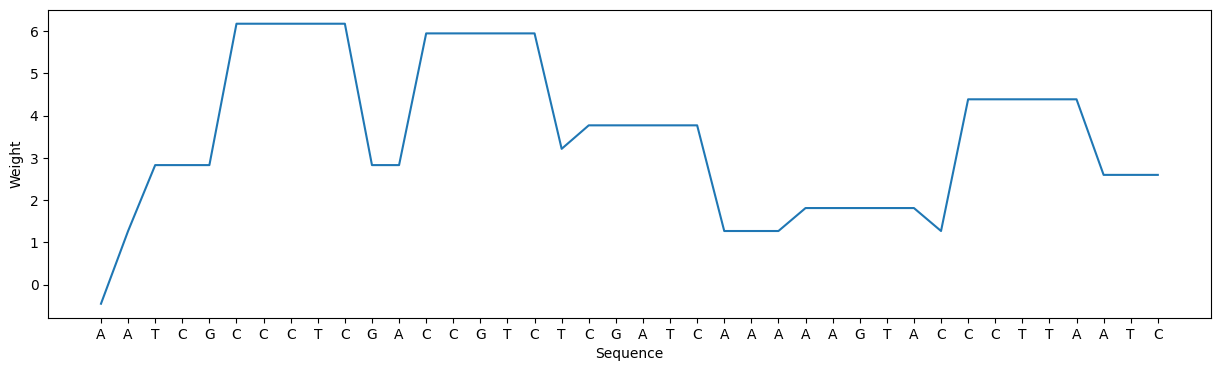

In [ ]:
ctcf_finder = MotifFinderPWM(ctcf_pcm)
profile = ctcf_finder.scan(seq, plot=True)

In [ ]:
profile

{(0, 5): -0.4508802057799311,
 (1, 6): 1.2694005969610787,
 (2, 7): 2.828580159563555,
 (3, 8): 2.4413921854689837,
 (4, 9): -inf,
 (5, 10): 6.1731565007641835,
 (6, 11): 2.5090621832853954,
 (7, 12): 1.2694005969610787,
 (8, 13): 2.828580159563555,
 (9, 14): 1.825295780724616,
 (10, 15): 0.165216198964437,
 (11, 16): -inf,
 (12, 17): 5.944385262809239,
 (13, 18): -inf,
 (14, 19): 3.213214111698857,
 (15, 20): 1.3370705947774901,
 (16, 21): 1.2694005969610787,
 (17, 22): -inf,
 (18, 23): 3.7691092954623944,
 (19, 24): -0.5186873962911949,
 (20, 25): 0.09740900845317327,
 (21, 26): 1.2692634042662265,
 (22, 27): 0.6533041922167105,
 (23, 28): -0.5186873962911949,
 (24, 29): -0.4508802057799311,
 (25, 30): -inf,
 (26, 31): 1.8124512852360064,
 (27, 32): 0.6533041922167105,
 (28, 33): 0.6533041922167105,
 (29, 34): 1.2694005969610787,
 (30, 35): -inf,
 (31, 36): -inf,
 (32, 37): 4.385068507511909,
 (33, 38): 0.6533041922167105,
 (34, 39): -inf,
 (35, 40): 2.5971177069544886}

# Поиск мотива в последовательности с помощью скрытой марковской модели:

In [ ]:
class HMM:
    def __init__(self, transitions, emissions, initial_transitions):
        self.transitions = transitions
        self.emissions = emissions
        self.initial_transitions = initial_transitions

    @staticmethod
    def forward(seq: str,
                transitions: np.array,
                emissions: np.array,
                initial_transitions: np.array) -> tuple[np.array, float]:

        alpha = np.zeros((seq.shape[0], emissions.shape[0]))
        alpha[0, :] = initial_transitions * emissions[:, seq[0]]

        for t in range(1, seq.shape[0]):
            for j in range(transitions.shape[0]):
                # Matrix Computation Steps
                #                  ((1x2) . (1x2))      *     (1)
                #                        (1)            *     (1)
                alpha[t, j] = alpha[t - 1].dot(transitions[:, j]) * emissions[j, seq[t]]
        # Likelihood of the sequence
        P = sum(alpha[-1, :] * transitions[:, -1])

        return alpha, P

    @staticmethod
    def backward(seq: str,
                 transitions: np.array,
                 emissions: np.array) -> np.array:

        beta = np.zeros((seq.shape[0], transitions.shape[0]))

        # setting beta(T) = 1
        beta[seq.shape[0] - 1] = transitions[:, -1] #np.ones((a.shape[0]))

        # Loop in backward way from T-1 to
        # Due to python indexing the actual loop will be T-2 to 0
        for t in range(seq.shape[0] - 2, -1, -1):
            for j in range(transitions.shape[0]):
                beta[t, j] = (beta[t + 1] * emissions[:, seq[t + 1]]).dot(transitions[j, :])

        return beta


    @staticmethod
    def encode_sequence(seq: str) -> np.array:
        encoding = {"A": 0, "C": 1, "G": 2, "T": 3}
        seq = np.array([encoding[base] for base in seq])
        return seq


    def forward_backward(self, seq: str) -> np.array:
        seq = self.encode_sequence(seq)
        fw, P = self.forward(seq, self.transitions, self.emissions, self.initial_transitions)
        bw = self.backward(seq, self.transitions, self.emissions)
        fb = (fw * bw) / P
        return fb


    @staticmethod
    def pcm_to_numpy(pcm: dict[str, list[float]]) -> np.array:
        """
        only for create_motif_model function
        """
        pcm = {i: pcm[i] for i in "ACGT"}
        pcm_np = np.array(list(pcm.values()))
        return pcm_np


    @classmethod
    def create_motif_model(cls,
                            pcm: dict[str, list[float]],
                            p_site: float):
        """
        Create model (HMM object) based on taken PCM and p_site
        """

        pcm = cls.pcm_to_numpy(pcm)
        len_site = pcm.shape[1]
        N_states = len_site + 2

        # transitions matrix
        bg_t = np.array([1 - p_site - 0.01, p_site, *[0]*(len_site-1), 0.01])
        motif_t = np.zeros([len_site, N_states])
        motif_t[:-1, 2:-1] = np.eye(len_site - 1)
        motif_t[-1, 0] = 1
        end_t = np.zeros(N_states)
        transitions = np.vstack([bg_t, motif_t, end_t])

        # emissions matrix
        bg_e = np.array([0.25] * 4)
        motif_e = pcm.T
        end_e = np.array([0] * 4)
        emissions = np.vstack([bg_e, motif_e, end_e])

        # initial
        initial_transitions = np.array([1, *[0]*(N_states - 1)])

        model = cls(transitions, emissions, initial_transitions)
        return model

In [ ]:
ctcf_pcm = {"A": [0, 0, 0, 0, 0],
            "C": [1, 1, 1, 0, 1],
            "T": [0, 0, 0, 1, 0],
            "G": [0, 0, 0, 0, 0]}

In [ ]:
ctcf_model = HMM.create_motif_model(ctcf_pcm, 0.1)

In [ ]:
fb = ctcf_model.forward_backward(seq)

In [ ]:
bg = fb[:, 0]
motif = fb[:, 1:-1].sum(axis=1)

Text(0, 0.5, 'Motif Probability')

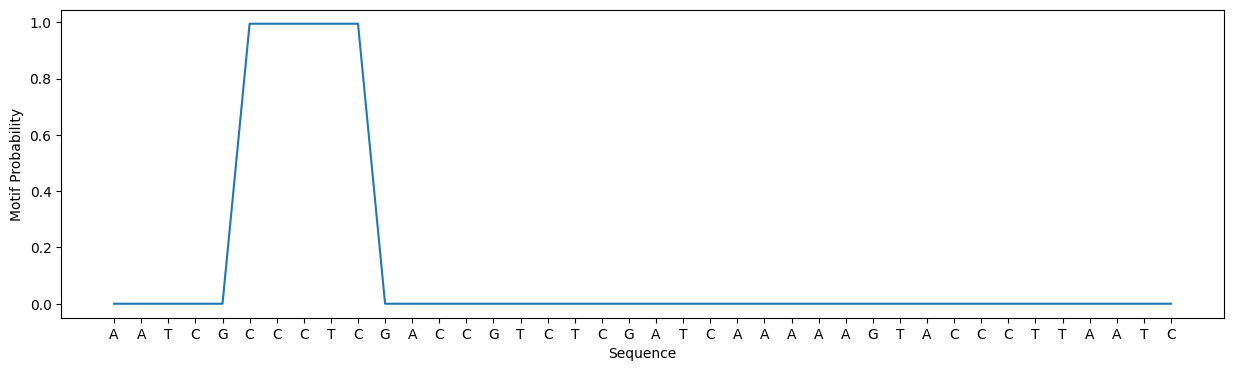

In [ ]:
fig, ax = plt.subplots(dpi=100, figsize=(15, 4))
ax.plot(motif)
ax.set_xticks(list(range(len(motif))), labels=list(seq))
ax.set_xlabel("Sequence")
ax.set_ylabel("Motif Probability")

In [ ]:
ctcf_pcm = {"A": [0.1, 0.03, 0.05, 0.01, 0.1],
            "C": [0.7, 0.91, 0.5 , 0.01, 0.7],
            "T": [0.1, 0.03, 0.05, 0.97, 0],
            "G": [0.1, 0.03, 0.4,  0.01, 0.2]}

In [ ]:
ctcf_model = HMM.create_motif_model(ctcf_pcm, 0.1)

Text(0, 0.5, 'Motif Probability')

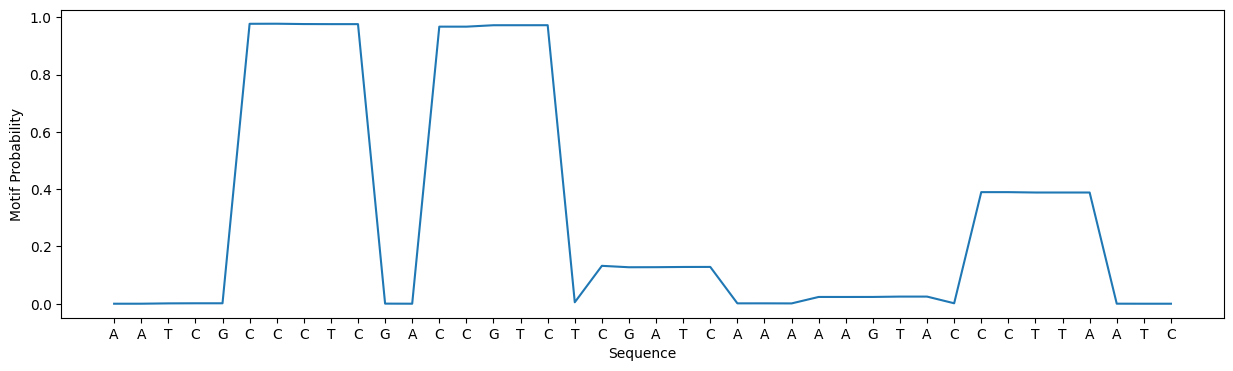

In [ ]:
fb = ctcf_model.forward_backward(seq)
bg = fb[:, 0]
motif = fb[:, 1:-1].sum(axis=1)

fig, ax = plt.subplots(dpi=100, figsize=(15, 4))
ax.plot(motif)
ax.set_xticks(list(range(len(motif))), labels=list(seq))
ax.set_xlabel("Sequence")
ax.set_ylabel("Motif Probability")

# Ещё один мотив:

In [ ]:
telomere_pcm = {"A": [0, 0, 1, 0, 0, 0],
                "C": [0, 0, 0, 0, 0, 0],
                "G": [0, 0, 0, 1, 1, 1],
                "T": [1, 1, 0, 0, 0, 0]}

sequence = "aaaattTTAGGGaTTAGGGcgcgaatctacgTTTGGGccccaaaaa".upper()

<ipython-input-71-066f77279dc9>:37: RuntimeWarning: divide by zero encountered in log2
  pwm = pcm * np.log2(pcm / MotifFinderPWM.bg)
<ipython-input-71-066f77279dc9>:37: RuntimeWarning: invalid value encountered in multiply
  pwm = pcm * np.log2(pcm / MotifFinderPWM.bg)


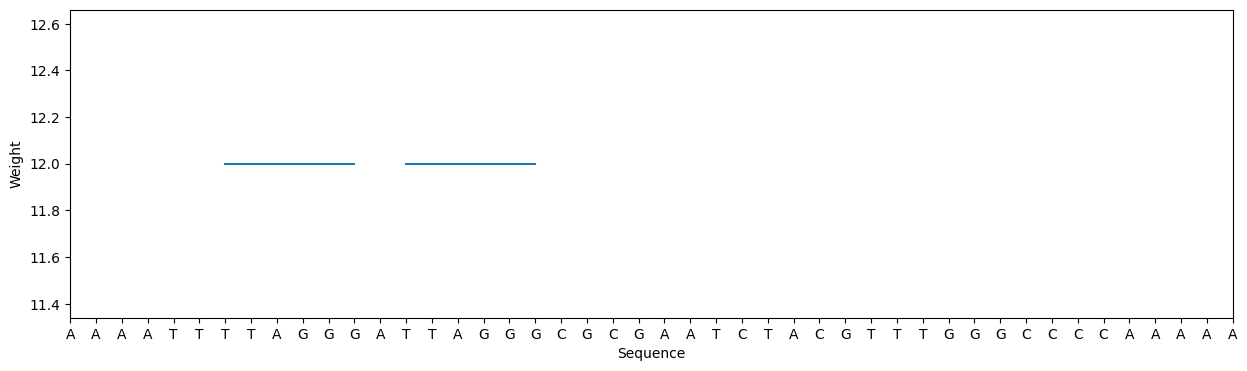

In [ ]:
telomere_finder = MotifFinderPWM(telomere_pcm)
profile = telomere_finder.scan(sequence, plot=True)

Text(0, 0.5, 'Motif Probability')

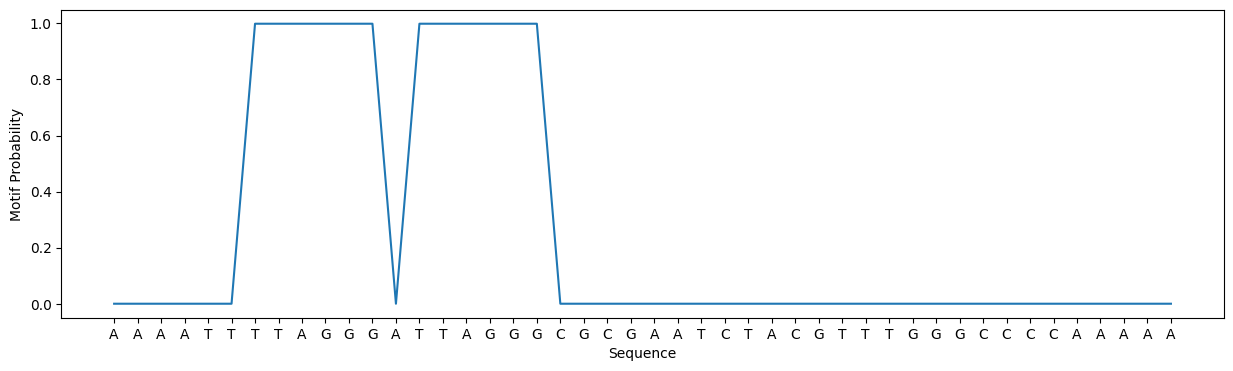

In [ ]:
telomere_model = HMM.create_motif_model(telomere_pcm, 0.1)

fb = telomere_model.forward_backward(sequence)
bg = fb[:, 0]
motif = fb[:, 1:-1].sum(axis=1)

fig, ax = plt.subplots(dpi=100, figsize=(15, 4))
ax.plot(motif)
ax.set_xticks(list(range(len(motif))), labels=list(sequence))
ax.set_xlabel("Sequence")
ax.set_ylabel("Motif Probability")

In [ ]:
telomere_pcm = {"A": [0.05, 0.04, 0.45, 0.05, 0.05, 0.04],
                "C": [0.20, 0.03, 0.45, 0.05, 0.05, 0.03],
                "G": [0.05, 0.03, 0.05, 0.80, 0.85, 0.90],
                "T": [0.70, 0.90, 0.05, 0.10, 0.05, 0.03]}

sequence = "aaaattTTAGGGaTTAGGGcgcgaatctacgTTTGGGccccaaaaa".upper()

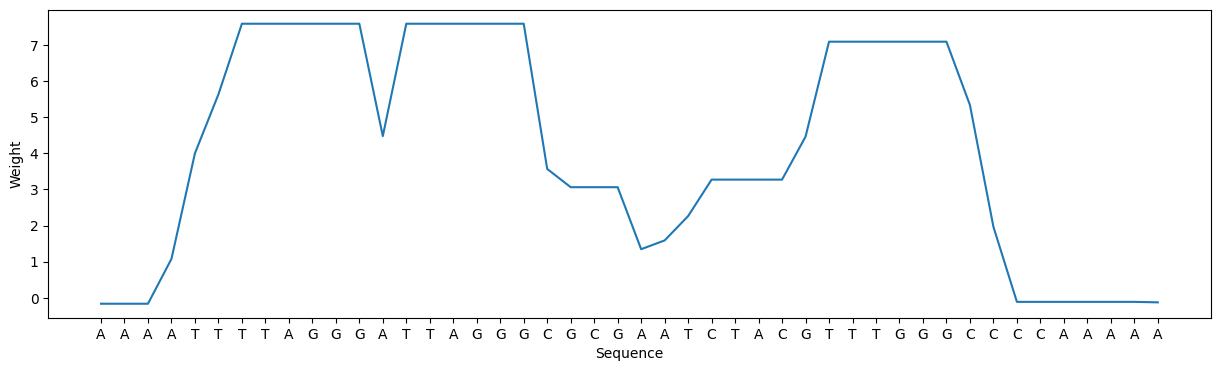

In [ ]:
telomere_finder = MotifFinderPWM(telomere_pcm)
profile = telomere_finder.scan(sequence, plot=True)

Text(0, 0.5, 'Motif Probability')

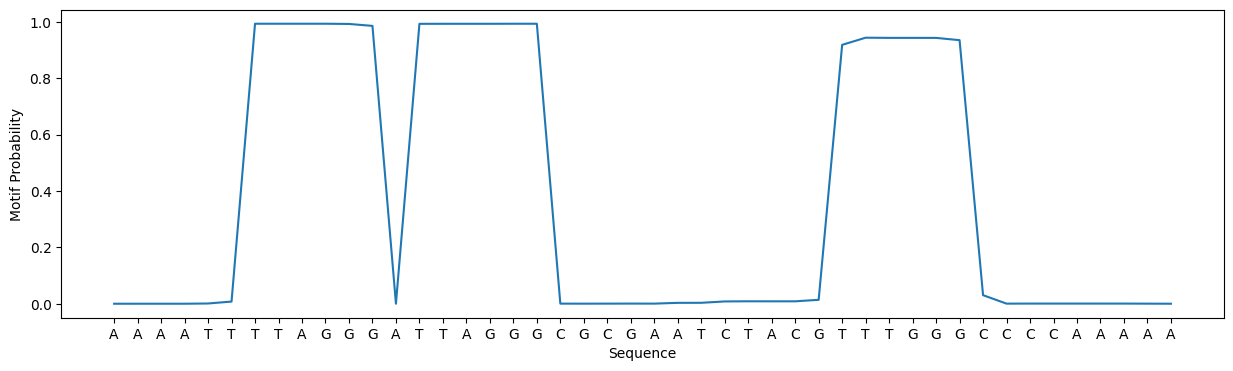

In [ ]:
telomere_model = HMM.create_motif_model(telomere_pcm, 0.1)

fb = telomere_model.forward_backward(sequence)
bg = fb[:, 0]
motif = fb[:, 1:-1].sum(axis=1)

fig, ax = plt.subplots(dpi=100, figsize=(15, 4))
ax.plot(motif)
ax.set_xticks(list(range(len(motif))), labels=list(sequence))
ax.set_xlabel("Sequence")
ax.set_ylabel("Motif Probability")